In [1]:

import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
import time as tm
import scanpy as sc
import anndata
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from scipy.io import mmread
import torch
from dataset import setup_seed,train_test_valid_loader_setup,get_accuracy #
from model import tre
from train import run_inference_for_epoch,get_evaluate_loss,lossplot
torch.set_default_tensor_type(torch.FloatTensor)
import pyro
from pyro.infer import SVI,  JitTraceEnum_ELBO, Trace_ELBO, config_enumerate
from pyro.optim import Adam, ExponentialLR
from sklearn.metrics import accuracy_score, f1_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:

input_path = "data549"
output_path = "outputa549"

In [3]:
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

In [4]:
#Set the missing initial value
setup_seed(233)
learning_rate =3e-4#1e-3
decay_rate = 0.97
enum_discrete = "parallel"
beta_1 = 0.99
cuda = True
float64 = False
config_enum = "parallel"
validation_fold = 0.1
batch_size = 30
test_size=0.3
unsuptrain_size=0.3
valid_size=0.1
sup_num, unsup_num = 0, 0

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [25]:


a549_dataset = {
                "gene_names": 'gene_names.txt',
                "gene_expression": 'rna_count.mtx',
                "cell_barcodes": 'cell_barcodes.txt',
                "atac_scores": 'atac_score.mtx',
                "label": 'label_file.csv',
                "mask": 'tf_gene.csv',
                }
datafile=mmread("{}/{}".format(input_path ,a549_dataset ["gene_expression"])).todense()
gene_names=pd.read_csv("{}/{}".format(input_path ,a549_dataset ["gene_names"]), header=None)
barcodes=pd.read_csv("{}/{}".format(input_path ,a549_dataset ["cell_barcodes"]), header=None)
acc_p=mmread("{}/{}".format(input_path ,a549_dataset ["atac_scores"])).todense()
mask=pd.read_csv("{}/{}".format(input_path ,a549_dataset ["mask"]), header=0,index_col=0)
label_file=pd.read_csv("{}/{}".format(input_path ,a549_dataset ["label"]), header=0,index_col=0)


In [26]:
datafile=pd.DataFrame(datafile.T,index=barcodes.values[:,0],columns=gene_names.values[:,0])
#Input data preprocess
tfname=mask
classnum=len(np.unique(label_file))
barcode=le.fit_transform(datafile.index.tolist())
label_file=label_file.values
datafile=datafile.values
acc_p=acc_p.T+0.01
acc_p=acc_p.astype(np.float32)
datafile=datafile.astype(np.float32)
mask=mask.values

In [7]:
#Setup dataloader

data_loaders = {'sup':None, 'unsup':None, 'valid':None ,'test':None}
data_loaders['sup'],data_loaders['valid'],data_loaders['unsup'],data_loaders['test'] = train_test_valid_loader_setup(datafile,label_file,acc_p,barcode,classnum,cuda,float64,batch_size,test_size, unsuptrain_size,valid_size)

In [8]:
#Setup model
z_dim=mask.shape[1]
output_size_rna = len(np.unique(label_file))
input_size_rna = datafile.shape[1]
mask_size = mask.shape[0]*mask.shape[1]
aux_loss=True

scc = tre(
    output_size = output_size_rna,
    input_size = input_size_rna,
    z_dim = z_dim,
    hidden_layers = [30],
    use_cuda = cuda,
    config_enum = enum_discrete,
    mask = mask,
    mask_size =mask_size,
    aux_loss_multiplier = 46,
    )
    
# setup the optimizer
adam_params = {'lr': learning_rate, 'betas':(beta_1, 0.999), 'weight_decay': 0.001}#0.001
#optimizer = Adam(adam_params)
optimizer = torch.optim.Adam
decayRate = decay_rate
scheduler = ExponentialLR({'optimizer': optimizer, 'optim_args': adam_params, 'gamma': decayRate})

pyro.clear_param_store()
# set up the loss(es) for inference, wrapping the guide in config_enumerate builds the loss as a sum
# by enumerating each class label form the sampled discrete categorical distribution in the model
guide = config_enumerate(scc.guide, enum_discrete, expand = True)
Elbo = JitTraceEnum_ELBO 
elbo = Elbo(max_plate_nesting = 1, strict_enumeration_warning = False)
loss_basic = SVI(scc.model, guide, scheduler, loss = elbo)


In [9]:
# build a list of all losses considered
losses = [loss_basic]
if aux_loss:
            elbo =  Trace_ELBO()
            loss_aux = SVI(scc.model_classify, scc.guide_classify, scheduler, loss = elbo)
            losses.append(loss_aux)
            loss_aux1 = SVI(scc.model_classify1, scc.guide_classify1, scheduler, loss = elbo)
            losses.append(loss_aux1)
    
num_epochs =50
decay_epochs =20
sup_num = data_loaders['sup'].dataset.data.shape[0]#细胞数
unsup_num = data_loaders['unsup'].dataset.data.shape[0]
valid_num=data_loaders['valid'].dataset.data.shape[0]
test_num=data_loaders['test'].dataset.data.shape[0]


3260

In [10]:
print(sup_num,unsup_num,valid_num,test_num)

1437 685 160 978


In [11]:

try:
        # seen across epochs over the supervised training set
        # and the corresponding testing set and the state of the networks
        best_valid_acc = 0.0
        best_valid_f1m = 0.0

        asso_valid_f1m = 0.0
        asso_valid_f1w = 0.0
        asso_valid_pre = 0.0
        asso_valid_rec = 0.0
        asso_valid_mcc = 0.0
        
        asso_unsup_acc = 0.0
        asso_unsup_f1m = 0.0
        asso_unsup_f1w = 0.0
        asso_unsup_pre = 0.0
        asso_unsup_rec = 0.0
        asso_unsup_mcc = 0.0
        
        tr_start=tm.time()
        unsupplosses=[]
        supplosses=[]
        vallosses=[]
        # run inference for a certain number of epochs
        for i in range(0, num_epochs):
            ep_tr_start = tm.time()

            # get the losses for an epoch
            
            epoch_losses_sup, epoch_losses_unsup = run_inference_for_epoch(
                data_loaders['sup'], data_loaders['unsup'], losses, cuda
            )
            epoch_losses_valid = get_evaluate_loss(
               data_loaders['valid'], losses, cuda
            ) 
            # compute average epoch losses i.e. losses per example
            avg_epoch_losses_sup = map(lambda v: v / sup_num, epoch_losses_sup)
            avg_epoch_losses_unsup = map(lambda v: v / unsup_num, epoch_losses_unsup) if unsup_num > 0 else [0] * len(epoch_losses_unsup)
            
            avg_epoch_losses_sup = map(lambda v: "{:.4f}".format(v), avg_epoch_losses_sup)
            avg_epoch_losses_unsup = map(lambda v: "{:.4f}".format(v), avg_epoch_losses_unsup)

            
            avg_epoch_losses_valid = map(lambda v: v /valid_num, epoch_losses_valid) if valid_num > 0 else [0] * len(epoch_losses_valid)
            avg_epoch_losses_valid = map(lambda v: "{:.4f}".format(v), avg_epoch_losses_valid)   
            # store the loss
            str_loss_sup = " ".join(map(str, avg_epoch_losses_sup))
            supplosses.append(str_loss_sup)

            str_loss_unsup = " ".join(map(str, avg_epoch_losses_unsup))
            unsupplosses.append(str_loss_unsup)
            
            str_loss_valid = " ".join(map(str, avg_epoch_losses_valid))
            vallosses.append(str_loss_valid) 
            str_print = "{} epoch: avg losses {}".format(
                i+1, "{} {} {}".format(str_loss_sup, str_loss_unsup,str_loss_valid)
            )

            validation_accuracy, validation_f1_macro, validation_f1_weighted, validation_precision, validation_recall, validation_mcc,ARI, NMI = get_accuracy(
                data_loaders["valid"], scc.classifier
            )

            str_print += " validation accuracy {:.4f}".format(validation_accuracy)
            str_print += " F1 {:.4f}(macro) {:.4f}(weighted)".format(validation_f1_macro, validation_f1_weighted)
            str_print += " precision {:.4f} recall {:.4f}".format(validation_precision, validation_recall)
            str_print += " mcc {:.4f}".format(validation_mcc)
            str_print += " ARI {:.4f} NMI {:.4f}".format(ARI, NMI)  

            
            unsup_accuracy, unsup_f1_macro, unsup_f1_weighted, unsup_precision, unsup_recall, unsup_mcc,ARI, NMI = get_accuracy(
                    data_loaders['unsup'], scc.classifier)
                           
            
            ep_tr_time = tm.time() - ep_tr_start
            str_print += " elapsed {:.4f} seconds".format(ep_tr_time)
            print(str_print)
            # update the best validation accuracy and the state of the parent 
            # module (including the networks)
            if best_valid_acc <= validation_accuracy:
                do_update = False
                if best_valid_acc < validation_accuracy:
                    do_update = True
                elif best_valid_f1m < validation_f1_macro:
                    do_update = True

                if do_update:
                    best_valid_acc = validation_accuracy
                    best_valid_f1m = validation_f1_macro
                    
                    asso_valid_f1m = validation_f1_macro
                    asso_valid_f1w = validation_f1_weighted
                    asso_valid_pre = validation_precision
                    asso_valid_rec = validation_recall
                    asso_valid_mcc = validation_mcc

                    
                    asso_unsup_acc = unsup_accuracy
                    asso_unsup_f1m = unsup_f1_macro
                    asso_unsup_f1w = unsup_f1_weighted
                    asso_unsup_pre = unsup_precision
                    asso_unsup_rec = unsup_recall
                    asso_unsup_mcc = unsup_mcc

            if i%decay_epochs == 0:
                scheduler.step() 


        tr_time=tm.time()-tr_start
        print('running time: {} secs'.format(tr_time))

        print(
            "best validation accuracy {:.4f}".format(
                best_valid_acc
            ),
        )
        print(
                "unsup accuracy: {:.4f} \nF1: {:.4f}(macro) {:.4f}(weighted) \nprecision {:.4f} recall {:.4f} \nmcc {:.4f}".format(
                    asso_unsup_acc, asso_unsup_f1m, asso_unsup_f1w, asso_unsup_pre, asso_unsup_rec, asso_unsup_mcc
                ),
            )

finally:print("train done") 


1 epoch: avg losses 10011.1211 2421.7600 9633.8869 3856.3124 2313.6227 2515.0989 3580.0536 2331.3592 2419.5154 validation accuracy 0.4133 F1 0.1950(macro) 0.2418(weighted) precision 0.1378 recall 0.3333 mcc 0.0000 ARI 0.0000 NMI 0.0000 elapsed 16.9993 seconds
2 epoch: avg losses 3350.8251 2388.9551 2498.9083 2820.8600 2281.7426 2440.8884 2543.6283 2259.4036 2365.2507 validation accuracy 0.3933 F1 0.1882(macro) 0.2258(weighted) precision 0.1320 recall 0.3278 mcc -0.0706 ARI -0.0020 NMI 0.0111 elapsed 4.9172 seconds
3 epoch: avg losses 2110.0397 2306.6086 2456.7177 1259.9582 2102.7239 2389.6778 1020.4318 2046.6878 2340.9753 validation accuracy 0.4200 F1 0.2601(macro) 0.3041(weighted) precision 0.6225 recall 0.3469 mcc 0.0368 ARI -0.0046 NMI 0.0213 elapsed 4.9267 seconds
4 epoch: avg losses 665.1563 1995.6254 2438.4954 462.8360 1692.5882 2361.5642 397.2006 1802.4030 2297.1845 validation accuracy 0.6000 F1 0.5723(macro) 0.5741(weighted) precision 0.6762 recall 0.5654 mcc 0.3806 ARI 0.2316 

In [ ]:
torch.save(scc.state_dict(), "%s/trevi10.30.pkl" % output_path)
output_size_rna = len(np.unique(label_file))
input_size_rna = datafile.shape[1]


In [19]:

scc = tre(
    output_size = output_size_rna,
    input_size = input_size_rna,
    z_dim = z_dim,
    hidden_layers = [30],
    use_cuda = cuda,
    config_enum = enum_discrete,
    mask = mask,
    mask_size =mask_size,
    aux_loss_multiplier = 46,
    )
scc.load_state_dict(torch.load("%s/trevi10.30.pkl" % output_path))
# predict
predictions, scores, actuals, zs, tf ,theta ,xss,barcodes= [], [], [], [], [],[],[],[]

# use the appropriate data loader
for (xs, ys,acc_p,barcode) in data_loaders['test']:
        # use classification function to compute all predictions for each batch
        yhats, yscores = scc.classifier_with_probability(xs)
        scores.append(yscores)

        _, yhats = torch.topk(yhats, 1)
        predictions.append(yhats.cpu().detach().numpy())

        _, ys = torch.topk(ys, 1)
        actuals.append(ys.cpu().detach().numpy())

        z=scc.latent_embedding(xs)
        zs.append(z.cpu().detach().numpy())

        tfs=abs(scc.predicted_tf(xs))
        tf.append(tfs.cpu().detach().numpy())

        xss.append(xs.cpu().detach().numpy())
        barcodes.append(barcode.cpu().detach().numpy())


predictions = np.concatenate(predictions, 0)
scores = torch.cat(scores, dim=0).cpu().detach().numpy()
actuals = np.concatenate(actuals, 0)
zs = np.concatenate(zs, 0)
tf = np.concatenate(tf, 0)
xss= np.concatenate(xss, 0)
barcodes= np.concatenate(barcodes, 0)

temp=np.array(torch.tensor(actuals.reshape(-1,1))).astype(str)
dict={'0':'0h', '1': '1h', '2': '3h'}
temp1= np.vectorize(dict.get)(temp)
temppre=np.array(torch.tensor(predictions.reshape(-1,1))).astype(str)
temppre1= np.vectorize(dict.get)(temppre)

test_accuracy, test_f1_macro, test_f1_weighted, test_precision, test_recall, test_mcc,ARI, NMI = get_accuracy(
                    data_loaders["test"], scc.classifier
                )
str_print1 = " test accuracy {:.4f}".format(test_accuracy)
str_print1 += " F1 {:.4f}(macro) {:.4f}(weighted)".format(test_f1_macro, test_f1_weighted)
str_print1 += " precision {:.4f} recall {:.4f}".format(test_precision, test_recall)
str_print1 += " mcc {:.4f}".format(test_mcc)            
str_print1 += " ARI {:.4f} NMI {:.4f}".format(ARI, NMI)  
print("accuracy:{:.4f}, f1_macro:{:.4f}, f1_weighted:{:.4f},ARI:{:.4f}, NMI:{:.4f}".format(test_accuracy,test_f1_macro,test_f1_weighted ,ARI,NMI))


accuracy:0.7677, f1_macro:0.7708, f1_weighted:0.7683,ARI:0.4168, NMI:0.3720


... storing 'cell_type' as categorical


         Falling back to preprocessing with `sc.pp.pca` and default params.


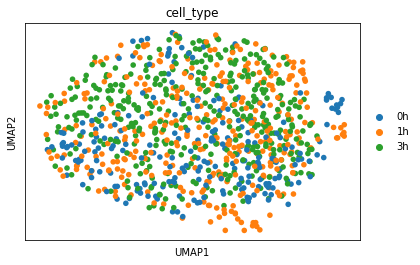

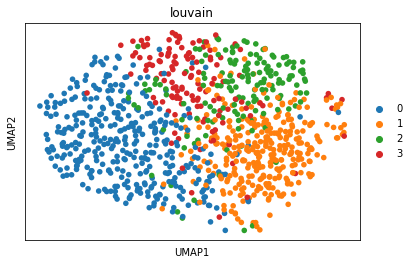

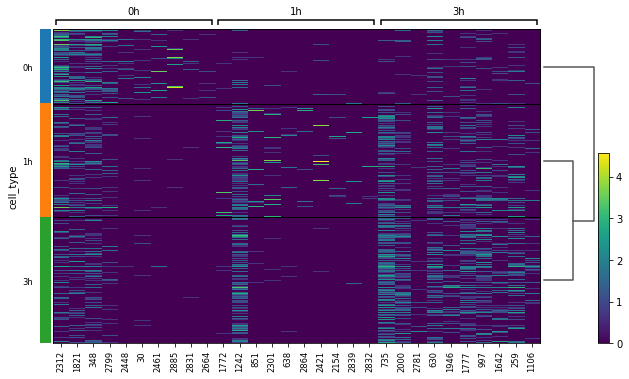

In [20]:

# visulization
prior_adata = anndata.AnnData(X=xss)
prior_adata.obsm["X_multi_vi"] = xss
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=30)
sc.tl.umap(prior_adata, min_dist=0.3)

sc.tl.louvain(prior_adata)
originalcell=prior_adata.obs['louvain']
prior_adata.obs['cell_type'] = temp1
# origin cell label
sc.pl.umap(prior_adata, color=['cell_type'], show=False)
plt.savefig("%s/xs_actual_label.pdf" % output_path, format="pdf")
# origin cell label
sc.pl.umap(prior_adata, color=['louvain'], show=False)
plt.savefig("%s/xs_predict_labl.pdf" % output_path, format="pdf")
        
sc.tl.rank_genes_groups(prior_adata, 'cell_type', method="t-test")
sc.pl.rank_genes_groups_heatmap(prior_adata, n_genes=10, groupby='cell_type', show=False)
plt.savefig("%s/xs_heatmap.pdf" % output_path, format="pdf")
groundtruth=prior_adata.obs['cell_type']


In [21]:

from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import adjusted_rand_score

In [22]:
ARI1 = adjusted_rand_score(groundtruth.ravel(), originalcell.ravel())
NMI1 = normalized_mutual_info_score(groundtruth.ravel(), originalcell.ravel())

accuracy1 = accuracy_score(groundtruth.ravel(), originalcell.ravel())
f1_macro1 = f1_score(groundtruth.ravel(), originalcell.ravel(), average='macro')
f1_weighted1 = f1_score(groundtruth.ravel(), originalcell.ravel(), average='weighted')
print("xs accuracy:{:.4f}, f1_macro:{:.4f}, f1_weighted:{:.4f},ARI:{:.4f}, NMI:{:.4f}".format(accuracy1,f1_macro1  ,f1_weighted1 ,ARI1,NMI1))
   


xs accuracy:0.0000, f1_macro:0.0000, f1_weighted:0.0000,ARI:0.0072, NMI:0.0228


... storing 'cell_type' as categorical
... storing 'cell_type pre' as categorical


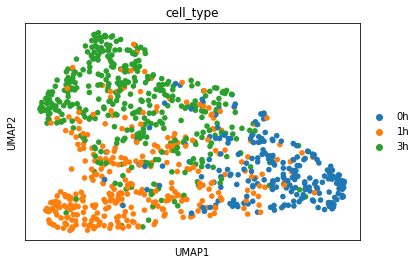

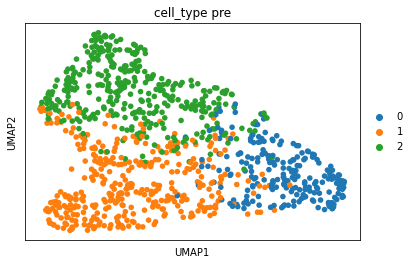

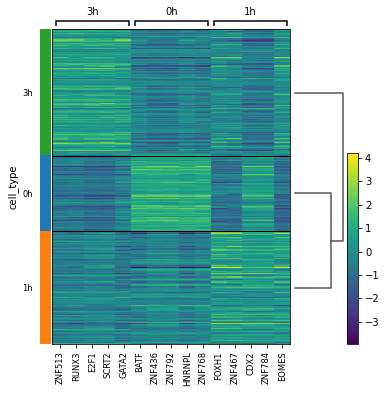

In [28]:
genename=pd.DataFrame(tfname.index)
tfname1=pd.DataFrame(tfname.columns)
prior_adata1 = anndata.AnnData(X=zs,var=tfname1)
prior_adata1.obsm["X_multi_vi"] = zs
sc.pp.neighbors(prior_adata1, use_rep="X_multi_vi", n_neighbors=20)
sc.tl.umap(prior_adata1, min_dist=0.3)

sc.tl.louvain(prior_adata1)
prior_adata1.obs['cell_type'] = temp1
# origin cell label
sc.pl.umap(prior_adata1, color=['cell_type'], show=False)

plt.savefig("%s/ztf_actual_labl.pdf" % output_path, format="pdf")
# plt.show()
prior_adata1.obs['cell_type pre'] = temppre
# origin cell label
sc.pl.umap(prior_adata1, color=['cell_type pre'], show=False)
plt.savefig("%s/ztf_predict_labl.pdf" % output_path, format="pdf")
prior_adata1.var.index=prior_adata1.var[0]
sc.tl.rank_genes_groups(prior_adata1, 'cell_type', method="t-test")
sc.pl.rank_genes_groups_heatmap(prior_adata1, n_genes=5, groupby='cell_type', show=False)
plt.savefig("%s/ztf_heatmap.pdf" % output_path, format="pdf")
